# Home Assignment No. 2 ( Practice)
To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

To begin with, let's import the essential (for this assignment) libraries.

# Task 2. MRI T1 image segmentation (15 points)

#### To get maximum points you are to:
-  1. Attach your working notebook in `hw2` archive **(2 pts)**
-  2. Attach the trained model with model.state_dict and provide the code for prediction below **(2 pts)**
-  3. Write an abstract what experiments, validation setups, and fine-tunings brought you to the best DICE score **(2 pts)**
-  4. Segment `100206, 100307, 100408` patients with `DICE score > 0.9` for the defined list of brain regions **(4 pts)**
- 5. Create and save a panel with a view in Comet or W&B or Tensorbord. It should be super nice. **(5 pts)**


 * **Extra points**: best result `Surface Distance Metrics` **(5 pts)**

To get the `norm.nii` files from `*.mgz` for these three patients I've entered the `docker container` from `Seminar 2` 
https://github.com/adasegroup/NEUROML2021/tree/master/seminar2

And in `freesurfer environement` convert `*.mgz` files to `*.nii` files. You can use the following script:

```   ### path: path to folder with subject to process
      ### basename: root path

      # saving names for normalised and aseg files
      F_NORM="$(find $path/mri/ -name "*norm.mgz")";
      F_PARC="$(find $path/mri/ -name "*aparc+aseg.mgz")";
      
      # echo "$F_NORM file $2/$(basename $1)_$(basename $path)_norm.nii.gz" 
      # echo "$F_PARC file $2/$(basename $1)_$(basename $path)_aparc+aseg.nii.gz"

      # converting files to needed format
      mri_convert -it "mgz" -ot "nii" "$F_NORM" "$2/$(basename $1)_$(basename $path)_norm.nii.gz";
      mri_convert -it "mgz" -ot "nii" "$F_PARC" "$2/$(basename $1)_$(basename $path)_aparc+aseg.nii.gz";
```        

See documentation: https://surfer.nmr.mgh.harvard.edu/fswiki/mri_convert

Yeah, we already did it for you. And now you have the ground truth to compare your result in `/fs_segmentation/`. 
**Please do not cheat with it**: either pretraining model or in any other way using the ground truth for your prediction. 

## Part 2: provide the code for prediction below (2 pts)

In [ ]:
### BEGIN Solution

# >>> your solution here <<<

### END Solution

In [26]:
CHANNELS_DIMENSION = 6
SPATIAL_DIMENSIONS = 2, 3, 4

VENTRCL =  [4,5,15,43,44,72]# 1
BRN_STEM = [16] # 2
HIPPOCMPS = [17, 53] # 3
AMYGDL = [18, 54] # 4
GM = [1002, 1003, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
       1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024,
       1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035,
       2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035] # 5

LABELS = VENTRCL + BRN_STEM + HIPPOCMPS + AMYGDL + GM # all of interest


def prepare_aseg(targets):
    """
    The function binarises the data  with the LABEL list.
   """
    targets = np.where(np.isin(targets, LABELS, invert = True), 0, targets)
    targets = np.where(np.isin(targets, VENTRCL), 1, targets)
    targets = np.where(np.isin(targets, BRN_STEM), 2, targets)
    targets = np.where(np.isin(targets, HIPPOCMPS), 3, targets)
    targets = np.where(np.isin(targets, AMYGDL), 4, targets)
    targets = np.where(np.isin(targets, GM), 5, targets)


    return targets

In [28]:
def get_model_and_optimizer(device, num_encoding_blocks=4, out_channels_first_layer=8, patience=3):
    #Better to train with num_encoding_blocks >=3, out_channels_first_layer>=4 '''
    #repoducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
    model = UNet(
          in_channels=1,
          out_classes=6,
          dimensions=3,
          num_encoding_blocks=num_encoding_blocks,
          out_channels_first_layer=out_channels_first_layer,
          normalization='batch',
          upsampling_type='linear',
          padding=True,
          activation='PReLU',
      ).to(device)
      
    optimizer = torch.optim.AdamW(model.parameters())
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.01)
    
    return model, optimizer, scheduler

model, optimizer, scheduler = get_model_and_optimizer(0)

In [29]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import nibabel

def plot_central_cuts(img, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        if (len(img.shape) > 3):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    axes[0].imshow(img[ img.shape[0] // 2, :, :])
    axes[1].imshow(img[ :, img.shape[1] // 2, :])
    axes[2].imshow(img[ :, :, img.shape[2] // 2])
    
    plt.show()
    
def plot_predicted(img, seg, delta = 0, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if (len(img.shape) == 5):
            img = img[0,0,:,:,:]
        elif (len(img.shape) == 4):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
        
    if isinstance(seg, torch.Tensor):
        seg= seg[0].cpu().numpy().astype(np.uint8)
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2 + delta, :, :])
    axes[1].imshow(seg[ seg.shape[0] // 2 + delta, :, :])
    intersect = img[ img.shape[0] // 2 + delta, :, :] + seg[ seg.shape[0] // 2 + delta, :, :]*100
    axes[2].imshow(intersect, cmap='gray')
    
    plt.show()

### Part 3: write an abstract what experiments, validation setups,and fine-tunings brought you to the best DICE score **(2 pts)**

<font color='green'> Place for your abstract.</font>

...

### Part 4: segment 100206, 100307, 100408 patients with DICE score > 0.9 for the defined list of brain regions (4 points)

*Please be sure, you we training on the same labels `LIST_ASEG`*:

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import nibabel

def plot_central_cuts(img, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        if (len(img.shape) > 3):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2, :, :])
    axes[1].imshow(img[ :, img.shape[1] // 2, :])
    axes[2].imshow(img[ :, :, img.shape[2] // 2])
    
    plt.show()
    
def plot_predicted(img, seg, delta = 0, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if (len(img.shape) == 5):
            img = img[0,0,:,:,:]
        elif (len(img.shape) == 4):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
        
    if isinstance(seg, torch.Tensor):
        seg= seg[0].cpu().numpy().astype(np.uint8)
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2 + delta, :, :])
    axes[1].imshow(seg[ seg.shape[0] // 2 + delta, :, :])
    intersect = img[ img.shape[0] // 2 + delta, :, :] + seg[ seg.shape[0] // 2 + delta, :, :]*100
    axes[2].imshow(intersect, cmap='gray')
    
    plt.show()

## Test subjects:

In [31]:
### BEGIN Solution

# >>> your solution here <<<

### END Solution

In [32]:
test_subjects = [100206, 100307, 100408]
test_norm_dir = './test'

testing_data_list = pd.DataFrame({
    'Subject': test_subjects,
    'norm': [f'{test_norm_dir}/HCP_T1_fs6_{subject}_norm.nii.gz' for subject in test_subjects],
    'aseg': [f'{test_norm_dir}/HCP_T1_fs6_{subject}_aparc+aseg.nii.gz' for subject in test_subjects]
})



testing_data, testing_subjects = get_torchio_dataset(testing_data_list['norm'], testing_data_list['aseg'], False)
testing_set = torchio.SubjectsDataset(testing_subjects)
testing_data_list.head()

,Subject,norm,aseg
0,100206,./test/HCP_T1_fs6_100206_norm.nii.gz,./test/HCP_T1_fs6_100206_aparc+aseg.nii.gz
1,100307,./test/HCP_T1_fs6_100307_norm.nii.gz,./test/HCP_T1_fs6_100307_aparc+aseg.nii.gz
2,100408,./test/HCP_T1_fs6_100408_norm.nii.gz,./test/HCP_T1_fs6_100408_aparc+aseg.nii.gz


In [33]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
model.load_state_dict(torch.load('models/model_6_classes_4_blocks_8_chanels.pth'))

<All keys matched successfully>

In [34]:
# !git clone https://github.com/deepmind/surface-distance.git
# !pip install surface-distance/
from surface_distance import metrics

In [56]:
def validate(label, pred):
    ''' Computes DICE and Hausdorf95 measures
    '''

    test_res = pd.DataFrame(columns = ['DICE_1', 'DICE_2', 'DICE_3', 'DICE_4', 'DICE_5',
                                      'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3', 'Hausdorff95_4', 'Hausdorff95_5'])
    # class 1
    distances = metrics.compute_surface_distances((label[0] == 1), (pred[0].numpy() == 1), [1,1,1])
    test_res.at[0,'DICE_1'] = metrics.compute_dice_coefficient((label[0] == 1), (pred[0].numpy() == 1))
    test_res.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    # class 2
    distances = metrics.compute_surface_distances((label[0] == 2), (pred[0].numpy() == 2), [1,1,1])
    test_res.at[0,'DICE_2'] = metrics.compute_dice_coefficient((label[0] == 2), (pred[0].numpy() == 2))
    test_res.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    # class 3
    distances = metrics.compute_surface_distances((label[0] == 3), (pred[0].numpy() == 3), [1,1,1])
    test_res.at[0,'DICE_3'] = metrics.compute_dice_coefficient((label[0] == 3), (pred[0].numpy() == 3))
    test_res.at[0,'Hausdorff95_3'] = metrics.compute_robust_hausdorff(distances, 95)
    # class 4
    distances = metrics.compute_surface_distances((label[0] == 4), (pred[0].numpy() == 4), [1,1,1])
    test_res.at[0,'DICE_4'] = metrics.compute_dice_coefficient((label[0] == 4), (pred[0].numpy() == 4))
    test_res.at[0,'Hausdorff95_4'] = metrics.compute_robust_hausdorff(distances, 95)
    # class 5
    distances = metrics.compute_surface_distances((label[0] == 5), (pred[0].numpy() == 5), [1,1,1])
    test_res.at[0,'DICE_5'] = metrics.compute_dice_coefficient((label[0] == 5), (pred[0].numpy() == 5))
    test_res.at[0,'Hausdorff95_5'] = metrics.compute_robust_hausdorff(distances, 95)
    
    return test_res

##### Predicting subjects `100206`, `100307`,`100408`:

/trinity/home/e.kondratyeva/.local/lib/python3.8/site-packages/torchio/data/inference/aggregator.py:160: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message, RuntimeWarning)


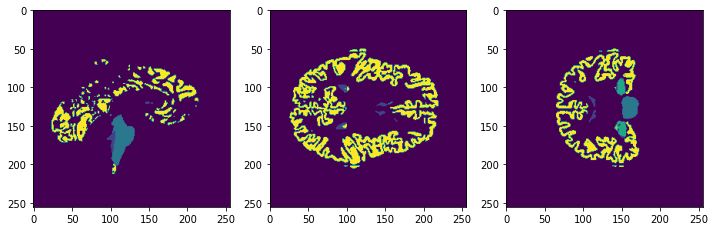

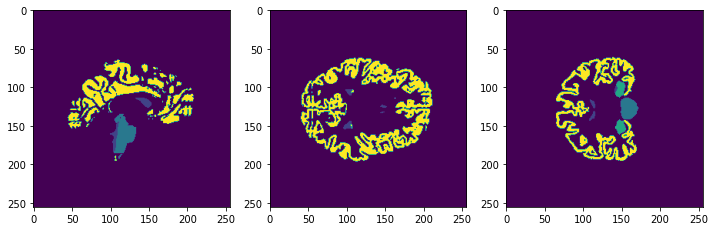

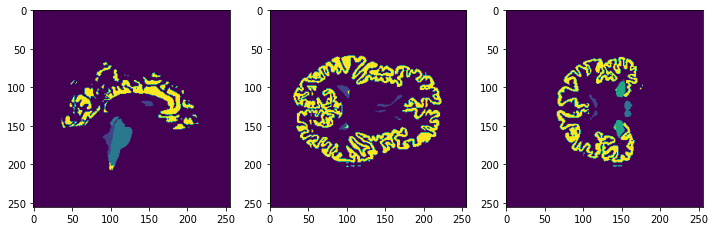

,DICE_1,DICE_2,DICE_3,DICE_4,DICE_5,Hausdorff95_1,Hausdorff95_2,Hausdorff95_3,Hausdorff95_4,Hausdorff95_5
0,0.909953,0.945721,0.916003,0.881886,0.870469,1.0,1.414214,1.0,1.0,2.0
1,0.908037,0.924606,0.90907,0.889132,0.907988,1.0,3.0,1.0,1.0,1.0
2,0.915632,0.952879,0.910146,0.877031,0.868691,1.0,1.0,1.0,1.0,1.732051


In [58]:
res_pivot = pd.DataFrame()
for i in range(0, len(testing_set)):
    sample = testing_set[i]
    patch_size = 64, 64, 64 
    patch_overlap = 20
    grid_sampler = torchio.inference.GridSampler(
        sample,
        patch_size,
        patch_overlap,
    )
    patch_loader = torch.utils.data.DataLoader(
        grid_sampler, batch_size=8)
    aggregator = torchio.inference.GridAggregator(grid_sampler)

    model.eval()
    with torch.no_grad():
        for patches_batch in patch_loader:
            inputs = patches_batch[MRI][DATA].to(device)
            locations = patches_batch['location']
            logits = model(inputs.float())
            labels = logits.argmax(dim=1, keepdim=True)
            aggregator.add_batch(labels, locations)
            
            
    pred = aggregator.get_output_tensor()
    label = prepare_aseg(testing_set[i][LABEL][DATA])
    plot_central_cuts(pred)
    temp_df = validate(label, pred)
    res_pivot = res_pivot.append(temp_df, ignore_index =True)

res_pivot

<font color='red'>Make sure, you are achieving better results, than this baseline either in terms of **DICE**, either **Hausdorff95 distance**.</font>

# Task 2. Comet ML/ W&b report panel (5 points)

Attach here a link to your public experiment in `Comet ML`:

This homework is intended on conducting the small and good experiment with its annotation. 
That is why, the `Comet ML` part is scored the most, so please put more effort into your results representation. 
The best pannel will be graded with **5 extra points.** as well as the most acurate solution.


Yes, you get a full solution it your hands, yet keep in mind - it is just your baseline. You should experiment with the augmentations, losses and build a story of your model development.